# Explain different DL models for Sleep Staging with Spectral Gradients

In [2]:
import numpy as np
import torch

from tqdm.notebook import tqdm

from captum.attr import IntegratedGradients, GradientShap

from pytorch_lightning import seed_everything

from physioex.data import PhysioExDataset

from physioex.train.networks import config as networks

from physioex.train.models import load_model
from physioex.explain.spectralgradients import SpectralGradients

torch.backends.cudnn.enabled = False
seed_everything(42)

Seed set to 42


42

In [5]:
### Load the model

selected_channels = ["EEG"]

model_name = "chambon2018"
model_kwargs = {
    "in_channels": len(selected_channels),
    "sequence_length": 21,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = load_model(
    model=model_name,
    model_kwargs=model_kwargs,
    softmax=True,
).eval()

1


In [12]:
# load dataset

if networks[model_name]["target_transform"] is not None:
    target_transform = networks[model_name]["target_transform"]
    import importlib

    module, function = target_transform.split(":")
    target_transform = getattr(importlib.import_module(module), function)
else:
    target_transform = None

dataset = PhysioExDataset(
    datasets=["shhs"],
    preprocessing="raw",
    selected_channels=selected_channels,
    sequence_length=model_kwargs["sequence_length"],
    target_transform=target_transform,
    data_folder="/mnt/guido-data/",
)

# define the explanation methods
ig = IntegratedGradients(model)
eg = GradientShap(model)

start_freq = 0.0001

# 50 bands means 1Hz resolution because the sampling rate is 100Hz
n_bands = 50
sg = SpectralGradients(model, n_bands=n_bands, mode="linear", start_freq=start_freq)
bands = sg.bands

Frequency bands: [[0.0001, 0.98], [0.98, 1.96], [1.96, 2.94], [2.94, 3.92], [3.92, 4.9], [4.9, 5.88], [5.88, 6.86], [6.86, 7.84], [7.84, 8.82], [8.82, 9.8], [9.8, 10.78], [10.78, 11.76], [11.76, 12.74], [12.74, 13.72], [13.72, 14.7], [14.7, 15.68], [15.68, 16.66], [16.66, 17.64], [17.64, 18.62], [18.62, 19.6], [19.6, 20.58], [20.58, 21.56], [21.56, 22.54], [22.54, 23.52], [23.52, 24.5], [24.5, 25.48], [25.48, 26.46], [26.46, 27.44], [27.44, 28.42], [28.42, 29.4], [29.4, 30.38], [30.38, 31.36], [31.36, 32.34], [32.34, 33.32], [33.32, 34.3], [34.3, 35.28], [35.28, 36.26], [36.26, 37.24], [37.24, 38.22], [38.22, 39.2], [39.2, 40.18], [40.18, 41.16], [41.16, 42.14], [42.14, 43.12], [43.12, 44.1], [44.1, 45.08], [45.08, 46.06], [46.06, 47.04], [47.04, 48.02], [48.02, 49.0]]


In [13]:
# sample the epochs with true classifications of Wake and NREM3

nrem3 = []
wake = []

nrem3_probas = []
wake_probas = []

# Disattiva il calcolo dei gradienti
with torch.no_grad():
    progress_bar = tqdm(dataset, desc=f"( {len(nrem3)} NREM3, {len(wake)} Wake )")

    for i, (x, y) in enumerate(progress_bar):
        # Interrompi il ciclo se abbiamo più di 50 epoche per ciascuna classe
        if min(len(nrem3), len(wake)) > 50:
            break

        # Prendi solo le epoche di DeepSleep (NREM3) o Wake
        if y != 3 and y != 0:
            continue

        # Aggiungi la dimensione del batch a x
        x = x.unsqueeze(0)

        # Calcola le probabilità con il modello
        probas = model(x.to(device)).detach().cpu()
        label = torch.argmax(probas, dim=1)

        # Aggiungi le epoche e le probabilità alle rispettive liste
        if label == 3:
            nrem3_probas.append(probas)
            nrem3.append(x)
        elif label == 0:
            wake_probas.append(probas)
            wake.append(x)

        # Aggiorna la descrizione della barra di progresso
        progress_bar.set_description(f"( {len(nrem3)} NREM3, {len(wake)} Wake )")

# Concatenazione dei tensori alla fine
if wake:
    wake = torch.cat(wake, dim=0)
if nrem3:
    nrem3 = torch.cat(nrem3, dim=0)

if nrem3_probas:
    nrem3_probas = torch.cat(nrem3_probas, dim=0)
if wake_probas:
    wake_probas = torch.cat(wake_probas, dim=0)

( 0 NREM3, 0 Wake ):   0%|          | 0/5347946 [00:00<?, ?it/s]

In [14]:
# method to compute the importances for all the instances in a batch
def compute_importances_batch(data_loader, label):
    ig_attrs = []
    eg_attrs = []
    sg_attrs = []

    with torch.no_grad():
        for x in tqdm(data_loader):
            x = x.to(device)

            # Integrated Gradients
            ig_attr = ig.attribute(x, target=label, n_steps=20).detach().cpu().numpy()
            ig_attrs.append(ig_attr)

            # Expected Gradients
            # draw 100 random samples from the dataset for baselines
            baselines = []
            for _ in range(100):
                x_baseline, _ = dataset[np.random.randint(0, len(dataset))]
                baselines.append(x_baseline.unsqueeze(0))
            baselines = torch.cat(baselines, dim=0).to(device)

            eg_attr = (
                eg.attribute(x, target=label, n_samples=20, baselines=baselines)
                .detach()
                .cpu()
                .numpy()
            )
            eg_attrs.append(eg_attr)
            del baselines

            # Saliency
            sg_attr = sg.attribute(x, target=label).detach().cpu().numpy()
            sg_attrs.append(sg_attr)

    ig_attrs = np.concatenate(ig_attrs, axis=0)
    eg_attrs = np.concatenate(eg_attrs, axis=0)
    sg_attrs = np.concatenate(sg_attrs, axis=0)

    return ig_attrs, eg_attrs, sg_attrs

In [15]:
from torch.utils.data import DataLoader

# Creare DataLoader per wake e nrem3
wake_loader = DataLoader(wake, batch_size=32, shuffle=False)
nrem3_loader = DataLoader(nrem3, batch_size=32, shuffle=False)

# Calcolare le importanze per tutte le istanze di wake e nrem3
wake_importances = compute_importances_batch(wake_loader, label=0)  # Wake label
nrem3_importances = compute_importances_batch(nrem3_loader, label=3)  # NREM3 label

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
ig_attr, eg_attr, sg_attr = wake_importances
print("Wake IG", ig_attr.shape)
print("Wake EG", eg_attr.shape)
print("Wake SG", sg_attr.shape)

ig_attr, eg_attr, sg_attr = nrem3_importances
print("NREM3 IG", ig_attr.shape)
print("NREM3 EG", eg_attr.shape)
print("NREM3 SG", sg_attr.shape)

Wake IG (51, 21, 1, 3000)
Wake EG (51, 21, 1, 3000)
Wake SG (51, 21, 1, 3000, 50)
NREM3 IG (53, 21, 1, 3000)
NREM3 EG (53, 21, 1, 3000)
NREM3 SG (53, 21, 1, 3000, 50)


In [19]:
# plot utility functions

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.interpolate import interp1d


def plot_sg_importances(signal, SG, title_suffix):
    signal, SG = signal[10, 0, :], SG[10, 0, :]
    fs = 100  # Frequenza di campionamento

    # Supponiamo che `signal` e `SG` siano già definiti
    # signal: il segnale originale
    # SG: le importanze spettrali

    # Calcola lo spettro di potenza
    frequencies, power_spectrum = welch(signal, fs=fs)
    spectral_importances = np.sum(SG, axis=0)

    # Interpolare le importanze spettrali per adattarle alla lunghezza dello spettro di potenza
    interp_func = interp1d(
        np.linspace(0, fs / 2, len(spectral_importances)),
        spectral_importances,
        kind="linear",
    )
    spectral_importances_interp = interp_func(frequencies)

    # Creare una figura con un subplot
    fig, ax = plt.subplots(figsize=(21, 8))

    # Tracciare lo spettro di potenza del segnale originale
    ax.plot(frequencies, power_spectrum, color="black")

    # Aggiungere un overlay colorato per mostrare le importanze spettrali con trasparenza
    for i in range(len(frequencies) - 1):
        color = plt.cm.coolwarm(
            (spectral_importances_interp[i] - min(spectral_importances_interp))
            / (max(spectral_importances_interp) - min(spectral_importances_interp))
        )
        ax.fill_between(
            frequencies[i : i + 2], power_spectrum[i : i + 2], color=color, alpha=0.6
        )

    # Delimitare le bande del sonno con linee verticali
    sleep_bands = {
        "Delta": (0.5, 4),
        "Theta": (4, 8),
        "Alpha": (8, 12),
        "Beta": (12, 30),
        "Gamma": (30, 50),
    }

    for band, (start, end) in sleep_bands.items():
        ax.axvline(x=start, color="grey", linestyle="--")
        ax.axvline(x=end, color="grey", linestyle="--")
        ax.text(
            (start + end) / 2,
            max(power_spectrum),
            band,
            horizontalalignment="center",
            verticalalignment="bottom",
        )

    # Aggiungere una barra di colore per riferimento delle importanze
    sm = plt.cm.ScalarMappable(
        cmap="coolwarm",
        norm=plt.Normalize(
            vmin=min(spectral_importances_interp), vmax=max(spectral_importances_interp)
        ),
    )
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Spectral Importance")

    # Impostare le etichette degli assi
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power Spectrum")

    ax.grid(False)

    # Mostrare la figura
    plt.tight_layout()
    # plt.savefig(f"{title_suffix}_sg.png", dpi=300)
    plt.show()
    plt.close()


def plot_importances(signal, IG, EG, title_suffix):
    signal, IG, EG = signal[10, 0, :], IG[10, 0, :], EG[10, 0, :]

    fig, ax = plt.subplots(2, 1, figsize=(21, 8), sharex="col", sharey="row")

    # Tracciare il segnale dell'epoca centrale in tutti i subplot con colore nero
    for i in range(2):
        ax[i].plot(np.arange(len(signal)), signal, color="black")

    # Aggiungere un overlay colorato per mostrare i punteggi di importanza con meno trasparenza
    # Overlay per IG Wake
    X, Y = np.meshgrid(np.arange(len(signal)), np.linspace(min(signal), max(signal), 2))
    im_ig_wake = ax[0].pcolormesh(
        X, Y, np.tile(IG, (2, 1)), cmap="coolwarm", alpha=0.6, shading="auto"
    )
    ax[0].set_title(f"Integrated Gradients (IG) - {title_suffix}")

    # Overlay per EG Wake
    im_eg_wake = ax[1].pcolormesh(
        X, Y, np.tile(EG, (2, 1)), cmap="coolwarm", alpha=0.6, shading="auto"
    )
    ax[1].set_title(f"Expected Gradients (EG) - {title_suffix}")

    # il segnale è 30s a 100Hz metti le etichette in secondi da 0 a 30
    ax[1].set_xticks(np.linspace(0, 3000, 11))
    ax[1].set_xticklabels(np.linspace(0, 30, 11).astype(int))

    # Impostare le etichette degli assi
    for a in ax:
        a.set_xlabel("Time")
        a.set_ylabel("Signal")

    # Aggiungere una barra di colore per riferimento delle importanze
    cbar_ig_wake = fig.colorbar(im_ig_wake, ax=ax[0], orientation="vertical")
    cbar_ig_wake.set_label("Importance (IG)")
    cbar_eg_wake = fig.colorbar(im_eg_wake, ax=ax[1], orientation="vertical")
    cbar_eg_wake.set_label("Importance (EG)")

    # Impostare i limiti degli assi y
    for a in ax:
        a.set_ylim(-3, 3)

    # aumenta il font size di tutta la figura
    plt.rcParams.update({"font.size": 24})

    # Mostrare la figura
    plt.tight_layout()
    # salva il plot in alta qualità
    # plt.savefig(f"{title_suffix}_ig.png", dpi=300)

    plt.show()
    plt.close()

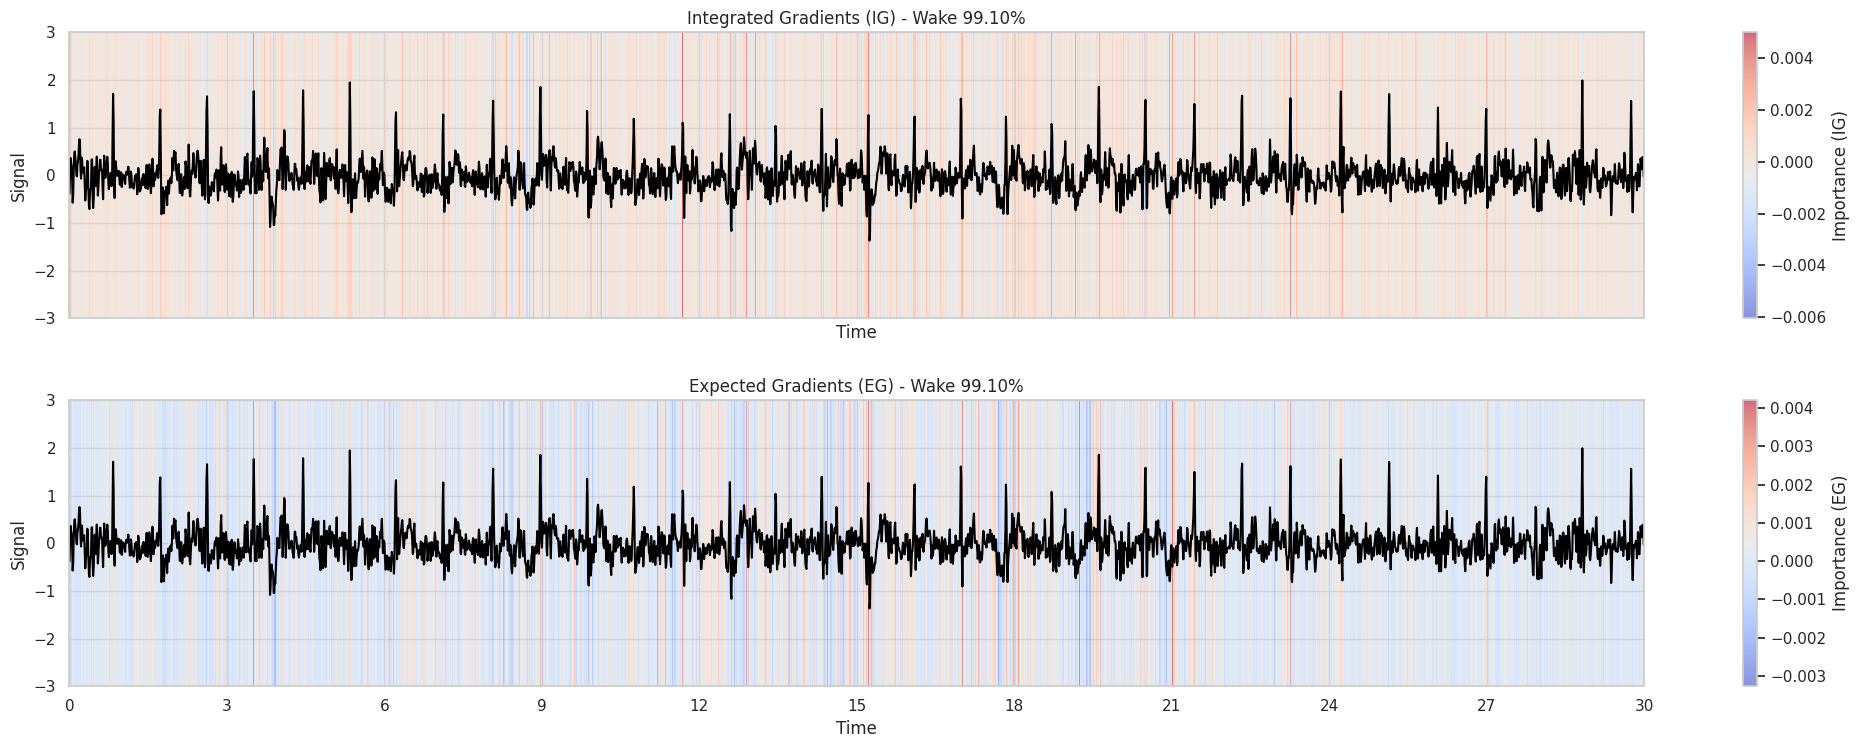

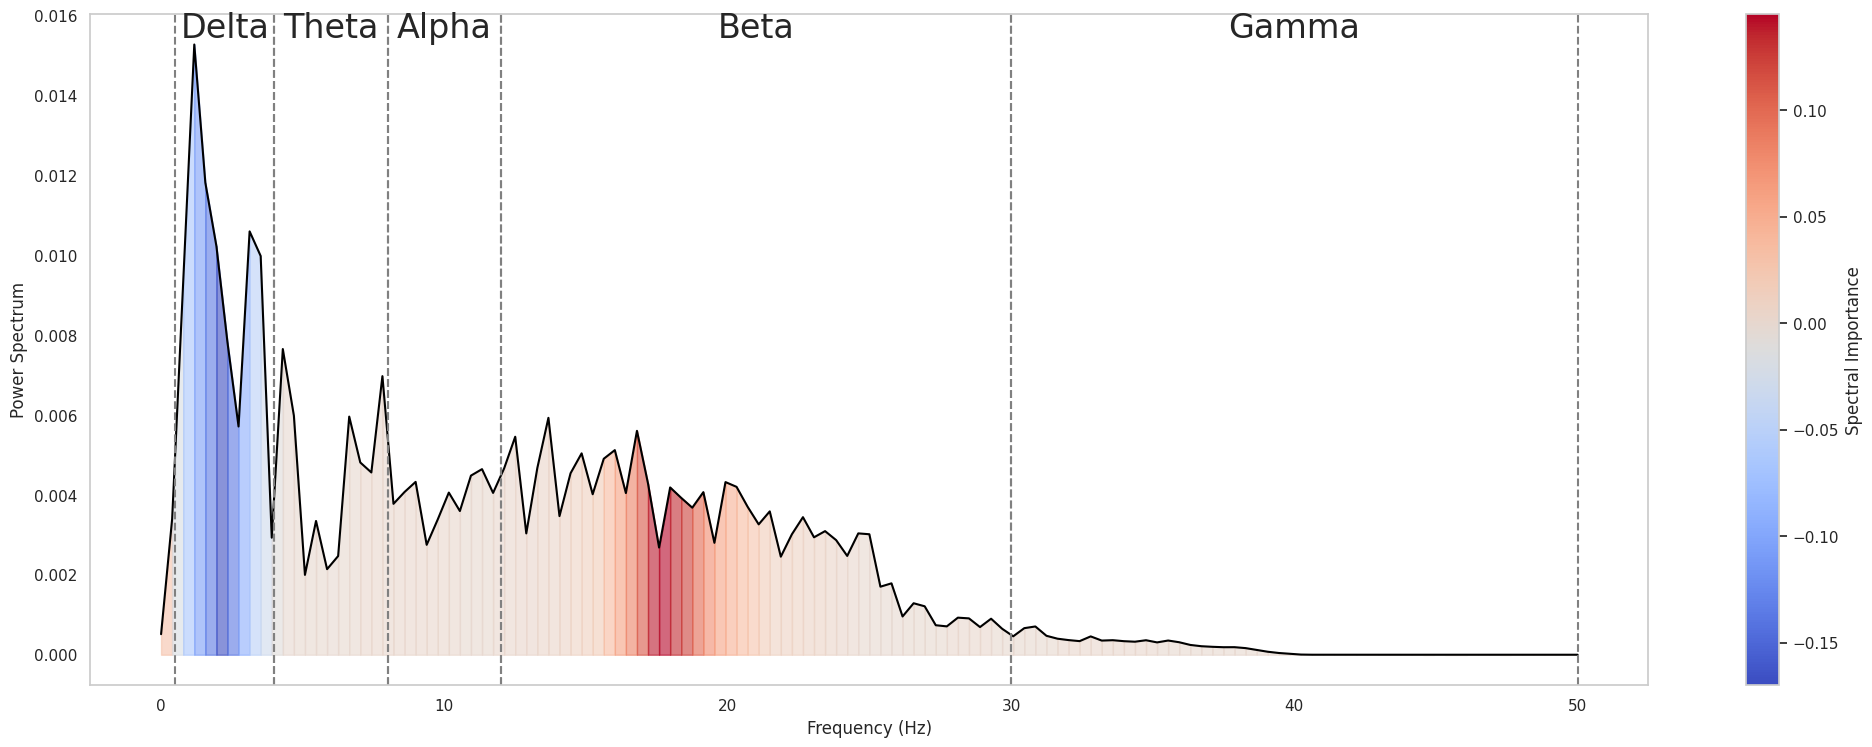

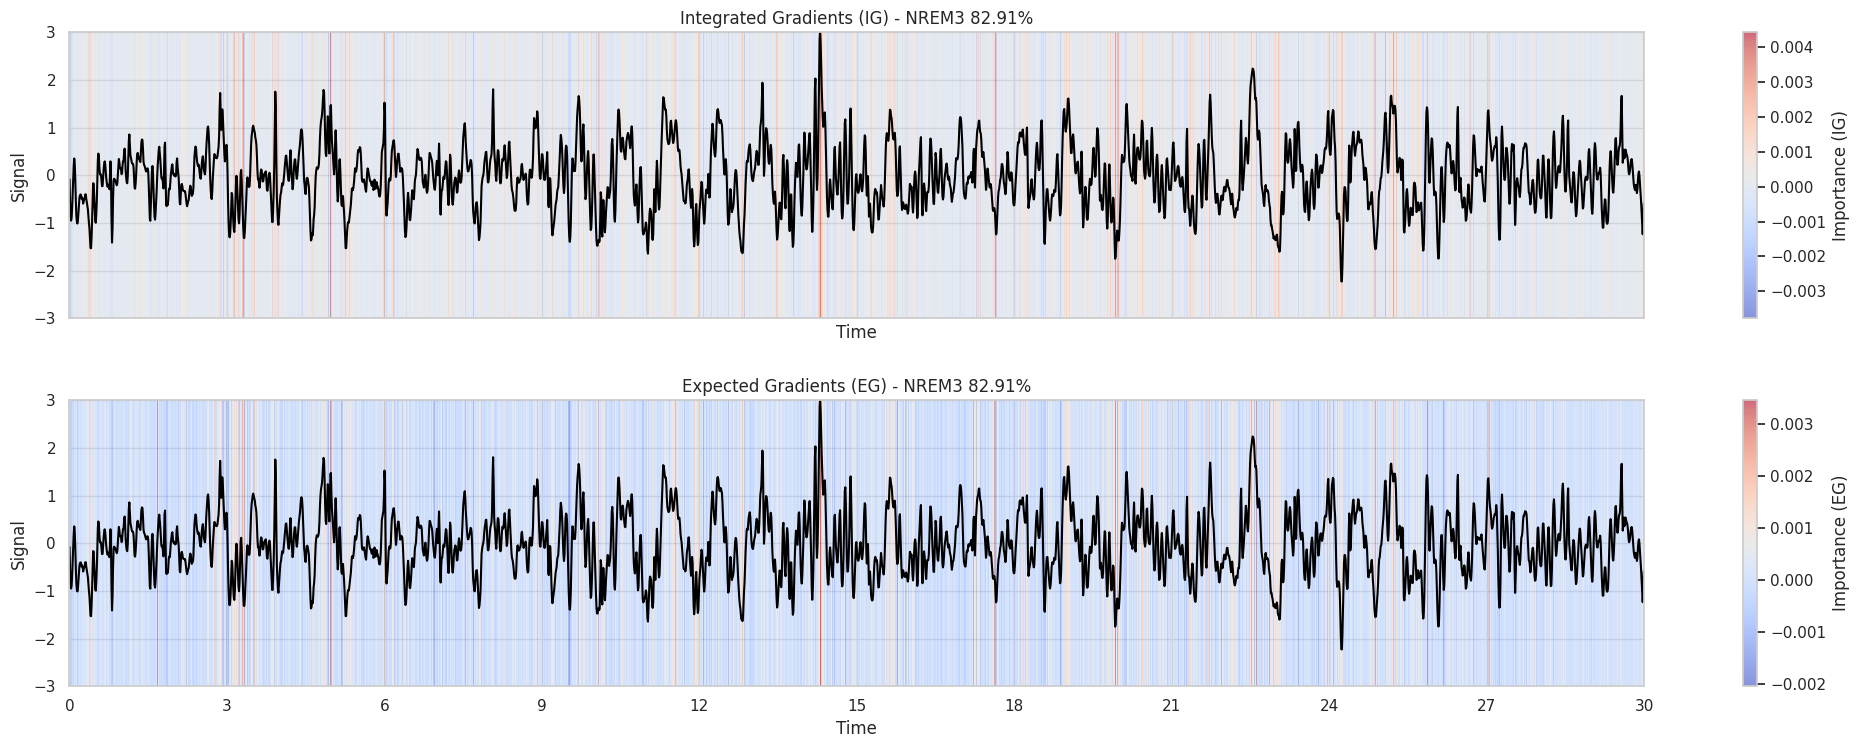

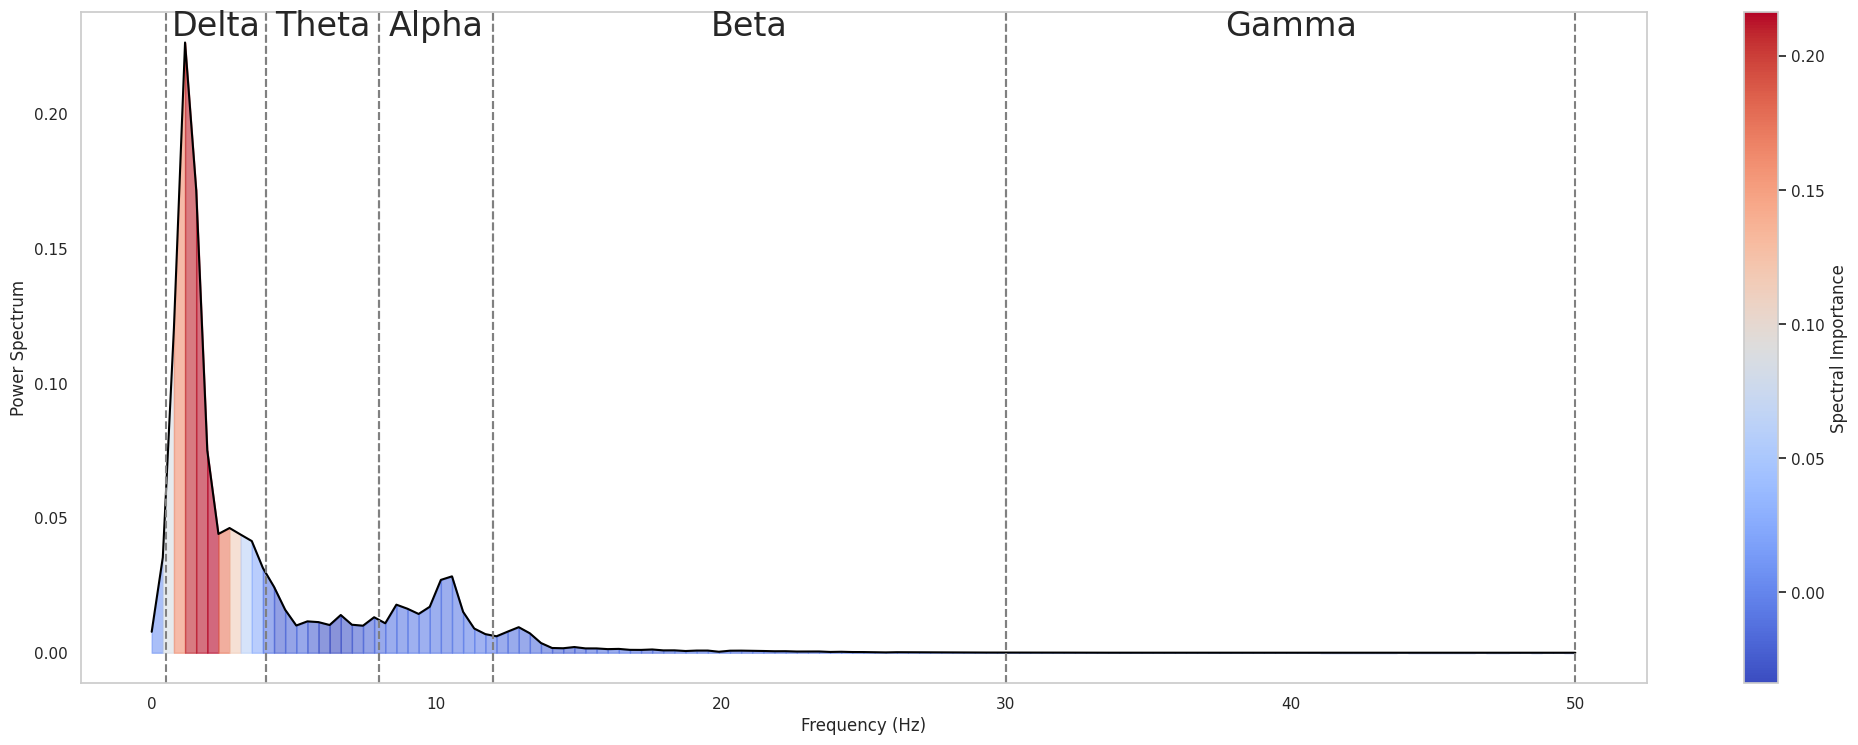

In [18]:
wake_ig, wake_eg, wake_sg = wake_importances
nrem3_ig, nrem3_eg, nrem3_sg = nrem3_importances

index = 1

probas_string = [f"{prob.item():.2f}%" for prob in wake_probas[index] * 100]
probas_string = probas_string[0]

plot_importances(wake[index], wake_ig[index], wake_eg[index], f"Wake {probas_string}")

plot_sg_importances(wake[index], wake_sg[index], "Wake")

index = 3

probas_string = [f"{prob:.2f}%" for prob in nrem3_probas[index] * 100]
probas_string = probas_string[3]

plot_importances(
    nrem3[index], nrem3_ig[index], nrem3_eg[index], f"NREM3 {probas_string}"
)

plot_sg_importances(nrem3[index], nrem3_sg[index], "NREM3")